# Intercomparison between the differnt atmospheric components
## pyOSOAA case study

This notebook is inspired by the computations realized by H. R. Gordon and M. Wang for the SeaWiFS satellite and it illustrates the use of the `pyOSOAA` python library.

The objetive here is to simulate the ocean-atmosphere system for a completely absorving ocean and from that be able to separate the glint, molecular and aerosol reflectances.

In [6]:
import numpy as np
import pyOSOAA
from pyOSOAA.osoaahelpers import RunWavelengths
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [7]:
# test pyOSOAA library
pyOSOAA.test()

OSOAA wrapper script by Francisco Nemiña
Inspired by Py6S wrapper by Robin Wilson
Using OSOAA located at /home/fnemina/Documents/SABIA-Mar/RT/OSOAA_V1.5
Running OSOAA using a set of test parameters
The results are:
Expected result: 0.128266
Actual result: 0.128266
#### Results agree, PyOSOAA is working correctly


## Introduction

A simple radiative transfer model for the top of the atmosphere radiance is given by

$$ \rho_t = \rho_r + \rho_a + \rho_{ra} + \rho_g + t\rho_w$$

where

$$\rho = \frac{\pi L}{F_0 \cos\theta_0}$$

and the subindices represent

- t  : Top of the atmosphere
- r  : molecular scattering
- a  : aerosol scattering
- ra : aerosol-molecular coupled scattering
- g  : glint
- w  : water

for a black ocean where $\rho_t \sim 0$ the component $\rho_a + \rho_{ra}$ can be solved from this equation.

We aim to do this in the present work for the SeaWiFS wavelengths and the find a simple model for

$$\rho_a + \rho_{ra} \sim \lambda^{-\alpha}$$

We will work with a sun-sensor relative acimuth angle of $90^\circ$, a sun zenith angle of $60^\circ$ and the sensor at nadir.

In [8]:
# We define SeaWiFS central wavelentghts
view = 0
wavelengths = np.array([412, 443, 490, 510, 555, 670, 765, 865])/1000

## Black ocean

The first calculation is to define a set of parameters that let us compute a black ocean. We do it as follows

In [9]:
s = pyOSOAA.OSOAA()

Here we have a very shallow ocean with no bottom albedo and no disolved material of any kind. We also set the wind speed to 10m/s

In [10]:
# Sea bottom configuration
s.sea.depth = 0.05
s.sea.bottype = 1
s.sea.botalb = 0

# Sea particles configuration
s.phyto.chl = 0
s.sed.csed = 0
s.det.abs440 = 0
s.ys.abs440 = 0

# Sea surface configuration
s.sea.wind = 10

We also confiure the view angles and the view level just below the surface

In [17]:
# Angles configuration
s.view.phi = 90
s.ang.thetas = 60

# Configure view level below the surface
s.view.level = 4

We run the results for different wavelengths and save the reflectance

In [18]:
rhowb = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

We run the same result above the surface

In [15]:
# Configure view level below the surface
s.view.level = 3

rhowa = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

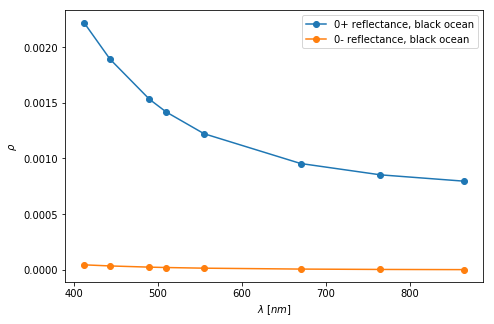

In [153]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhowa,'o-',label="0+ reflectance, black ocean")
plt.plot(wavelengths*1e3,rhowb,'o-',label="0- reflectance, black ocean")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

As we can see, the water leaving reflectances is not relevant compared to the glint, molecular and aerosol reflectances.

We define the black ocean as follows for the rest of this case study

```
# Sea bottom configuration
s.sea.depth = 0.05
s.sea.bottype = 1
s.sea.botalb = 0

# Sea particles configuration
s.phyto.chl = 0
s.sed.csed = 0
s.det.abs440 = 0
s.ys.abs440 = 0

# Sea surface configuration
s.sea.wind = 10
```

## Glint reflectance

We want to now compute the glint reflectance, to do this we will compute the water leaving radiance for a very low aerosol and molecular optical thickness

In [24]:
# Small optical thickness
s.ap.SetMot(0.0005)
s.aer.aotref = 0.00001

In [25]:
rhog = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

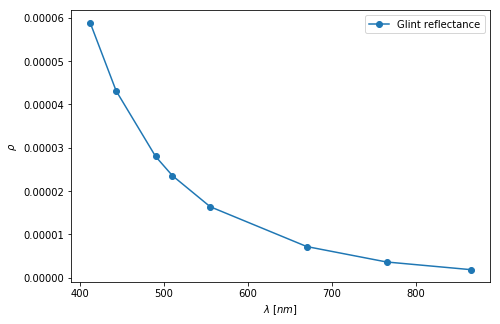

In [154]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhog,'o-',label="Glint reflectance")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

As we can see the glint reflectance behaves as spected.

## Molecular scattering

We now include the molecular scattering effect by setting the pressure to a standar pressure.

In [30]:
# Small optical thickness
s.ap.SetPressure(1013.25)

# Set view level at TOA
s.view.level = 1

In [31]:
rhor = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

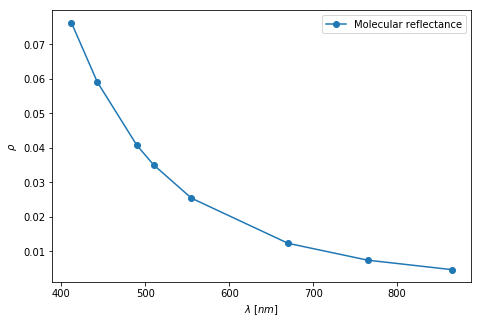

In [155]:
plt.figure(figsize=(7.5,5))
plt.plot(wavelengths*1e3,rhor,'o-',label="Molecular reflectance")
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

We can see that the glint reflectance is very small for the choseen geometry so we can take it as zero from now on.

## Aerosol scattering 

We now include the aerol scattering effect by setting the aerosol optical thickness to a nonzero value.

In [41]:
# We set the aerosol optical thickness
s.aer.aotref = 0.1
s.ap.SetMot(0.0005)

In [86]:
# Define aerosol models to compute
AerosolModels = {"T70":(1,70), "T90":(1,90), "T98":(1,98),
                 "M70":(3,70), "M90":(3,90), "M98":(3,98),
                 "C70":(4,70), "C90":(4,90), "C98":(4,98)}

color = {"T70":"v-C0", "T90":"v-C1", "T98":"v-C2",
         "M70":"o-C0", "M90":"o-C1", "M98":"o-C2",
         "C70":"s-C0", "C90":"s-C1", "C98":"s-C2"}

In [82]:
# Run the different models
results = {}

for key in AerosolModels.keys():
    model = AerosolModels[key]
    s.aer.SetModel(model=2, sfmodel=model[0], rh=model[1])
    results[key] = RunWavelengths(s, wavelengths, view)/np.cos(np.pi*view/180.0)

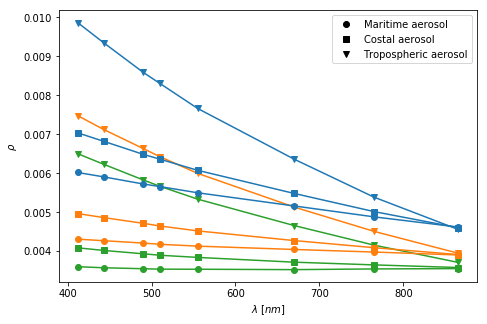

In [156]:
plt.figure(figsize=(7.5,5))
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")

for key in results.keys():
    plt.plot(wavelengths*1e3, results[key], color[key])
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\rho$"); plt.legend()
plt.show()

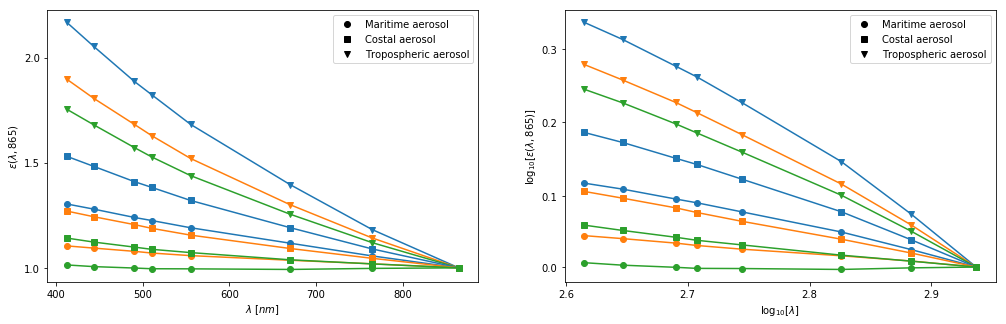

In [159]:
plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)
for key in results.keys():
    plt.plot(wavelengths*1e3, results[key]/results[key][-1], color[key])
plt.xticks([400,500,600,700,800]); plt.yticks([1.0,1.5,2.0])
plt.xlabel(r"$\lambda$ [$nm$]"); plt.ylabel(r"$\epsilon(\lambda,865)$")
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")
plt.legend()
plt.subplot(1, 2, 2)
for key in results.keys():
    plt.plot(wavelengths*1e3, results[key]/results[key][-1], color[key])
plt.loglog(basex=10,basey=10,subsx=[0],subsy=[0])
plt.xticks([398,501,631,794],[2.6,2.7,2.8,2.9])
plt.yticks([1,1.25,1.58,1.99,2.51],[0.0,0.1,0.2,0.3,0.4])
plt.xlabel(r"$\log_{10}[\lambda]$"); plt.ylabel(r"$\log_{10}[\epsilon(\lambda,865)]$")
plt.plot([],[],'ok',label="Maritime aerosol")
plt.plot([],[],'sk',label="Costal aerosol")
plt.plot([],[],'vk',label="Tropospheric aerosol")
plt.legend()
plt.show()